In [1]:
# General Imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import geopandas
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import warnings
import random
import time

import skimage
from skimage.transform import rescale
import cv2

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [2]:
# local imports
from dataloader_v5 import Dataset

In [3]:
# define paths
spot6_mosaic = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
spot6_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/"
sen2_path = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_loader/data/closest_dates.pkl"

# get dataset object
dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
print("Loader Length: ",len(loader))

precalculated dataset file found, loading...

Dataset Object successfully instanciated!
Loader Length:  68150


# Test Interpolation and Loss

In [222]:
def interpolate(img):
    import cv2
    """
    Input:
        - Image
    Output:
        - Image upsampled to 75*75
    """
    #img = rescale(img,6.6666666666666)
    img = cv2.resize(img, (500,500))
    return(img)


def downsample(img):
    """
    Input:
        - Image
    Output:
        - Image downsampled to 75*75
    """
    img = cv2.resize(img, (75,75))
    return(img)
    

# https://arxiv.org/abs/1603.08155
# https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html   
def ssim_calc(a,b):
    ssim_const = ssim(a, b,data_range=b.max() - b.min(),multichannel=True)
    return(ssim_const)


def mse_gray(a,b):
    a,b = np.dot(a[...,:3], [0.2989, 0.5870, 0.1140]),np.dot(b[...,:3], [0.2989, 0.5870, 0.1140])
    a,b = np.ndarray.flatten(a),np.ndarray.flatten(b)
    mse = (np.square(a - b)).mean(axis=None)
    return(mse)

def mse_rgb(a,b):
    a,b = np.ndarray.flatten(a),np.ndarray.flatten(b)
    mse = (np.square(a - b)).mean(axis=None)
    return(mse)
    
def mae_gray(a,b):
    from sklearn.metrics import mean_absolute_error
    a,b = np.dot(a[...,:3], [0.2989, 0.5870, 0.1140]),np.dot(b[...,:3], [0.2989, 0.5870, 0.1140])
    a,b = np.ndarray.flatten(a),np.ndarray.flatten(b)
    mae = mean_absolute_error(a, b)
    return(mae)

def mae_rgb(a,b):
    from sklearn.metrics import mean_absolute_error
    a,b = np.ndarray.flatten(a),np.ndarray.flatten(b)
    mae = mean_absolute_error(a, b)
    return(mae)


def psnr(a, b):
    # https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/#:~:text=Peak%20signal%2Dto%2Dnoise%20ratio%20(PSNR)%20is%20the,with%20the%20maximum%20possible%20power.
    # PSNR = 20*log(max(max(f)))/((MSE)^0.5)
    # result in db
    # lower->better
    try:
        import math
        mse = np.mean((a - b) ** 2)
        if(mse == 0):  # MSE is zero means no noise is present in the signal. Therefore PSNR have no importance.
            return 100
        max_pixel = 255.0
        psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
        return(psnr)
    except ValueError:
        return(0)
    
    
def lpips_calc(a,b):
    # lower->better
    #https://github.com/richzhang/PerceptualSimilarity
    import lpips
    
    # transpose to b,h,w
    a = np.transpose(a,(2,0,1))
    b = np.transpose(b,(2,0,1))
    # to torch
    a = torch.from_numpy(a)
    b = torch.from_numpy(b)
    #print(a.size(),b.size())
    
    loss_fn_vgg = lpips.LPIPS(net='alex',verbose=False)
    res = loss_fn_vgg(a,b)
    
    # back to NP and flatten
    res = res.detach().numpy()
    res = float(np.ndarray.flatten(res))
    return(res)

#Implement the following as losses

# implement lpips, https://github.com/richzhang/PerceptualSimilarity
# MSE pixel-wise
# PSNR - peak signal to noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


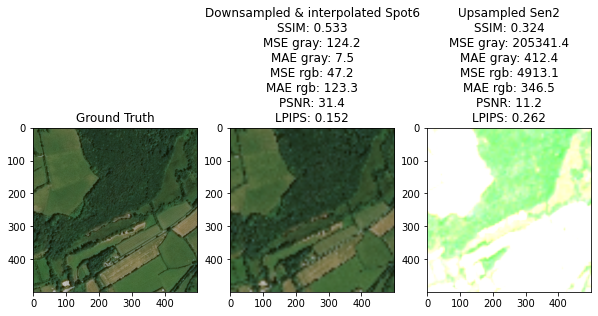

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


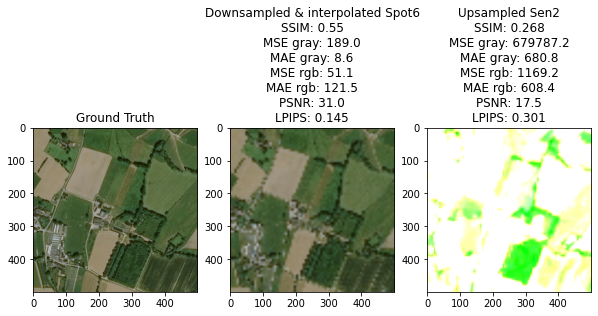

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


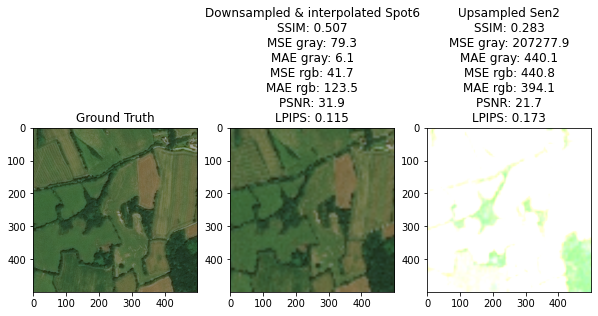

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


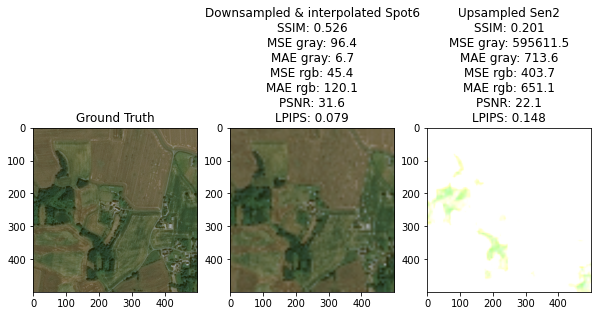

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


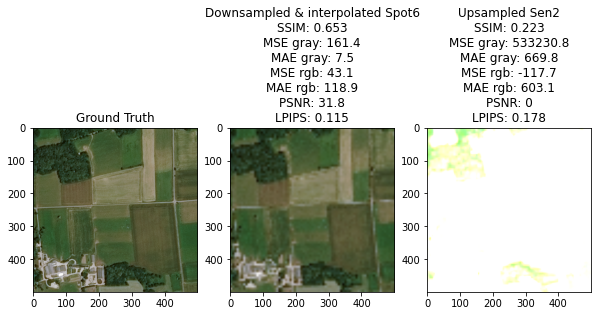

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


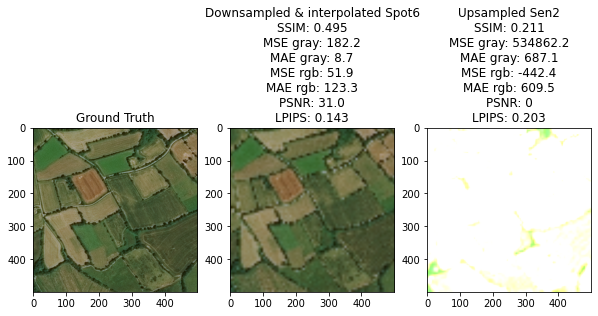

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


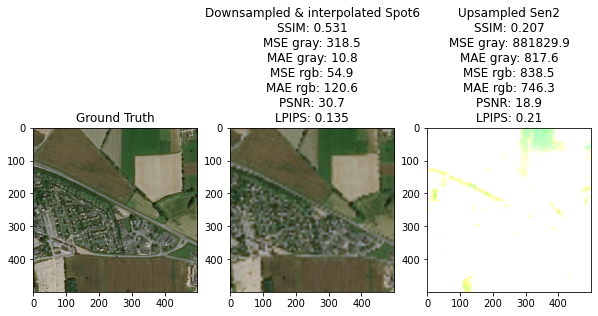

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


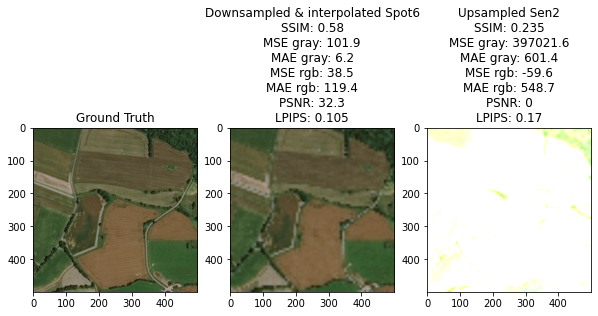

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


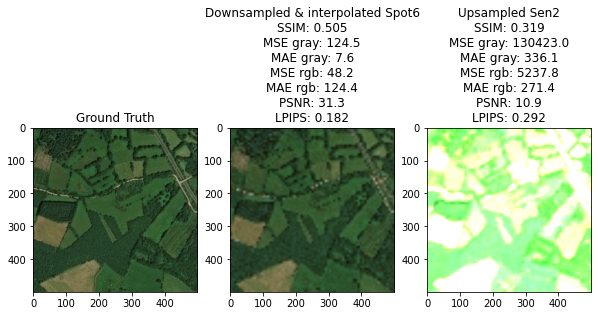

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


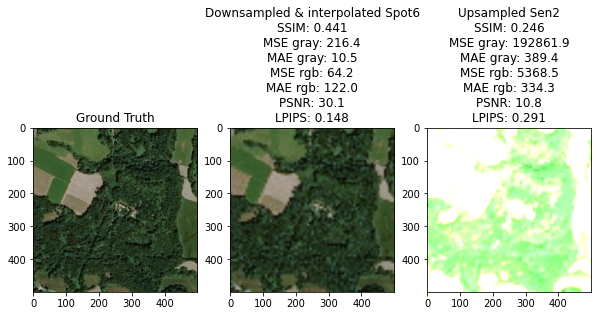

In [227]:
count = 0
for i in loader:
    
    a,b = dataset.__getitem__(random.randint(0,len(dataset)))
    
    a = np.transpose(a,(1,2,0))
    b = np.transpose(b,(1,2,0))
    
    a_upsampled = interpolate(downsample(a))
    b_interpolated = interpolate(b)
    
    ssim_upsampled_sen2 = round(ssim_calc(a,b_interpolated),3)
    ssim_upsampled_spot6 = round(ssim_calc(a,a_upsampled),3)
    mse_gray_sen2 = round(mse_gray(a,b_interpolated),1)
    mse_gray_spot6 = round(mse_gray(a,a_upsampled),1)
    mae_gray_sen2 = round(mae_gray(a,b_interpolated),1)
    mae_gray_spot6 = round(mae_gray(a,a_upsampled),1)
    mae_rgb_sen2 = round(mae_rgb(a,b_interpolated),1)
    mae_rgb_spot6 = round(mae_rgb(a,a_upsampled),1)
    mse_rgb_sen2 = round(mse_rgb(a,b_interpolated),1)
    mse_rgb_spot6 = round(mse_rgb(a,a_upsampled),1)
    psnr_sen2  = round(psnr(a,b_interpolated),1)
    psnr_spot6 = round(psnr(a,a_upsampled),1)
    lpips_sen2 = round(lpips_calc(a,b_interpolated),3)
    lpips_spot6 = round(lpips_calc(a,a_upsampled),3)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,5))
    ax1.imshow(a)
    ax1.set_title("Ground Truth")
    ax2.imshow(interpolate(downsample(a)))
    ax2.set_title("Downsampled & interpolated Spot6\nSSIM: "+str(ssim_upsampled_spot6)+"\nMSE gray: "+str(mse_gray_spot6)+
                 "\nMAE gray: "+str(mae_gray_spot6)+"\nMSE rgb: "+str(mse_rgb_spot6)+
                 "\nMAE rgb: "+str(mae_rgb_spot6)+"\nPSNR: "+str(psnr_spot6)+"\nLPIPS: "+str(lpips_spot6))
    ax3.imshow(interpolate(b))
    ax3.set_title("Interpolated Sen2\nSSIM: "+str(ssim_upsampled_sen2)+"\nMSE gray: "+str(mse_gray_sen2)+
                 "\nMAE gray: "+str(mae_gray_sen2)+"\nMSE rgb: "+str(mse_rgb_sen2)+
                 "\nMAE rgb: "+str(mae_rgb_sen2)+"\nPSNR: "+str(psnr_sen2)+"\nLPIPS: "+str(lpips_sen2))
    plt.show()
    
    
    # Define Break
    count = count+1
    if count==10:
        break

# Normalization

In [ ]:
dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)

In [228]:

def normalize(img):
    from torchvision import transforms
    transform_norm = transforms.Compose([
            #transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean=[479.0, 537.0, 344.0], std=[430.0, 290.0, 229.0]) ])
    img = transform_norm(img)
    img = img.numpy()[0]
    img = np.transpose(img,(1,2,0))
    return(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


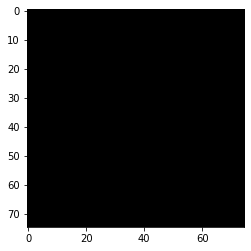

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


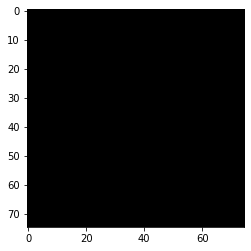

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


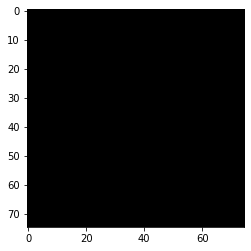

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


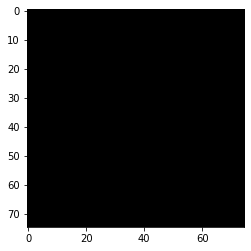

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


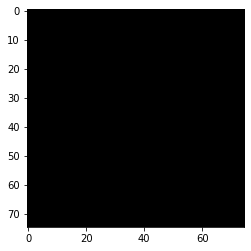

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


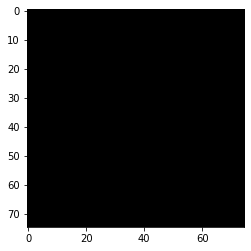

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


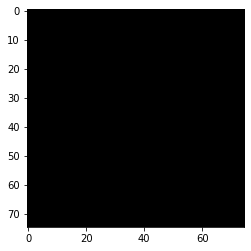

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


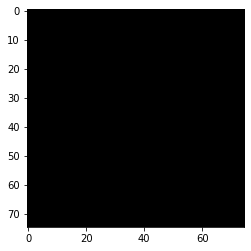

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


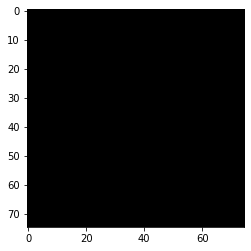

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


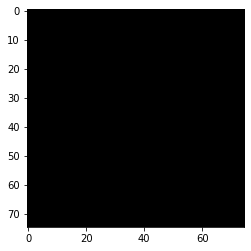

In [229]:
count = 0
for i in loader:
    a,b = i
    b = (normalize(b))

    
    #b *= 255.0/b.max()
    #b = ((b - b.min()) * (1/(b.max() - b.min()) * 255)).astype('uint8')
    
    plt.imshow(b)
    plt.show()
    #y = y.type(torch.LongTensor)
    #print(type(b))
    
    count=count+1
    if count==10:
        break

In [230]:
b

array([[[-1.1139301, -1.8516644, -1.5021539],
        [-1.1139177, -1.8516532, -1.5021337],
        [-1.1138995, -1.8516347, -1.5021138],
        ...,
        [-1.1138897, -1.8516339, -1.5021183],
        [-1.1138926, -1.8516351, -1.5021224],
        [-1.1138934, -1.8516376, -1.5021261]],

       [[-1.1139253, -1.8516654, -1.5021539],
        [-1.1139282, -1.8516645, -1.5021564],
        [-1.1139232, -1.8516614, -1.5021498],
        ...,
        [-1.1138906, -1.851632 , -1.5021207],
        [-1.1138929, -1.8516343, -1.5021211],
        [-1.1138933, -1.8516368, -1.5021197]],

       [[-1.1139209, -1.8516697, -1.5021479],
        [-1.1139226, -1.851667 , -1.5021468],
        [-1.1139256, -1.8516665, -1.5021514],
        ...,
        [-1.1138903, -1.8516328, -1.5021201],
        [-1.113888 , -1.8516332, -1.5021179],
        [-1.113889 , -1.8516357, -1.5021174]],

       ...,

       [[-1.1139439, -1.8516909, -1.5021718],
        [-1.1139436, -1.8516958, -1.5021703],
        [-1.1139361, -